In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.stats import chi2
import cython
%load_ext Cython


from KalmanFilter import KalmanFilter as KFPedro
from KF_py import KalmanFilter as KF
from KF_py2 import KalmanFilter as KF2
from KalmanFilter_Uni import KalmanFilter as KFU
from KalmanFilter_UniCy import KalmanFilter as KFUC

%load_ext autotime
%load_ext snakeviz

# Bayesian Econometrics - Final Paper

Paper to be delivered as the course's final paper

Pedro Montero Mattos

MPE - Econometria

\#333791

# The Model - Local Level with Seasonal Component

As described in the chapter 4 in Koopman et al. The local level model with a seasonal component consists of the following equations:

$$y_t = \mu_t + \gamma_t + \epsilon_t, \qquad \epsilon_t \sim NID(0,\sigma^2_\epsilon)$$

$$\mu_{t+1} = \mu_t + \xi_t, \qquad \xi_t \sim NID(0,\sigma^2_\xi) $$

$$\gamma_{t+1} = -\gamma_{t} - \gamma_{t-1} - \theta_1\gamma_{t-2} + \omega_t \sim NID(0,\sigma^2_\omega) $$


We added a $\theta$ coefficient in order to use maximum likelihood estimation

## State Space Form

General Form:

$$ y_t = Z x_t + \epsilon_t, \qquad \epsilon_t \sim NID(0,\sigma^2_\epsilon)$$
$$ x_{t+1} = T x_t + R_t \eta_T, \qquad \eta_t \sim NID(0,Qt) $$

In terms of the model:
$$ 
x_t = 
\begin{pmatrix}\mu_t \\ \gamma_t  \\  \gamma_{t-1}   \\ \gamma_{t-2}  \end{pmatrix}
$$

$$
\eta_t = 
\begin{pmatrix}\xi_t \\ \omega_t \end{pmatrix}
$$

$$
T_t = 
\begin{bmatrix} 
1 & 0 & 0 & 0 \\
0 & -1 & -1 & -\theta_1 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 
\end{bmatrix}
$$



$$
Z^T_t = 
\begin{pmatrix}1 \\ 1  \\  0   \\ 0  \end{pmatrix}
$$

$$
Q_t = 
\begin{bmatrix} 
\sigma^2_\xi & 0 \\
0 & \sigma^2_\omega \\
\end{bmatrix}
$$

$$
R_t = 
\begin{bmatrix} 
1 & 0  \\
0 & 1  \\
0 & 0  \\
0 & 0  \\
\end{bmatrix}
$$

$$
H_t = 
\begin{bmatrix} 
\sigma^2_\epsilon
\end{bmatrix}
$$

# Generating the data for $\theta_1=0.7$

We have to choose all parameter values plus the initial states

$$\gamma_t = \gamma_{t-1} = \gamma_{t-2} = 0$$
$$\theta_1 = 0.7$$
$$\sigma^2_\xi = 0.1$$
$$\sigma^2_\omega = 0.2$$
$$\sigma^2_\epsilon = 0.3$$




In [2]:
n = 200
theta1 = 0.7
sigmaXi = 0.1
sigmaOmega = 0.2
sigmaEpsilon = 0.3

time: 1 ms


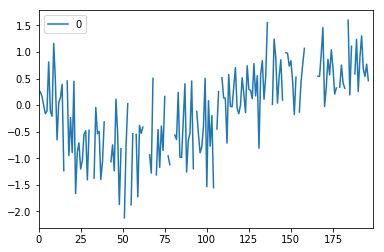

time: 378 ms


In [3]:
y = np.array([0])
mi = np.array([0])
gamma = np.array([0])

xi = np.array([0])
omega = np.array([0])
ep = np.array([0])

for i in range(1,n):

    # Level equation
    xi = np.append(xi,np.random.normal(scale=sigmaXi))
    mi = np.append(mi,mi[i-1]+xi[i])
    
    # Seasonality equation
    omega = np.append(omega,np.random.normal(scale=sigmaOmega))
    holder = 0
    if i-1 >= 0:
        holder -= gamma[i-1] 
    if i-2 >= 0:
        holder -= gamma[i-2] 
    if i-3 >= 0:
        holder -= gamma[i-3] * theta1
    
    gamma = np.append(gamma,holder+omega[i])
    
    # Series equation
    ep = np.append(ep,np.random.normal(scale=sigmaEpsilon))
    y = np.append(y,mi[i]+gamma[i]+ep[i])

y = pd.DataFrame(y) 
mi = pd.DataFrame(mi) 
gamma = pd.DataFrame(gamma) 


probNan= 0.20
for i in y.index:
    ran = np.random.uniform(size=y.iloc[i].shape)
    y.iloc[i][ran<probNan] = np.nan



y.plot()

# Maximum Likelihood Estimates

Define a wrapper function that maps the theta vector of parameters to the state space matrices

$$\theta = [\theta_1, \sigma^2_\epsilon, \sigma^2_\xi, \sigma^2_\omega]'$$

The functions return the negative of the likelihood because the scipy optimization algorithms only minimize functions. Also we use the logarithm for numerical reasons.

In [4]:
def wrapper(theta):
    T = pd.DataFrame([
        [1,0,0,0],
        [0,-1,-1,-theta[0]],
        [0,1,0,0],
        [0,0,1,0],
    ])

    H = pd.DataFrame([theta[1]])

    Q = pd.DataFrame([
        [theta[2],0],
        [0,theta[3]],
    ])

    kf = KF(y=np.array(y), 
                      Z=np.array(Z.astype(float)), 
                      H=np.array(H.astype(float)), 
                      T=np.array(T.astype(float)), 
                      Q=np.array(Q.astype(float)), 
                      a1=np.zeros((4)), 
                      P1=np.identity(4), 
                      R=np.array(R.astype(float)), 
                      nStates=4,)    

    return -np.log(kf['ll']*10e6)

time: 9.03 ms


## Define the additional state space matrices

In [5]:
Z = pd.DataFrame([
        [1,1,0,0],
    ])

R = pd.DataFrame([
        [1,0],
        [0,1],
        [0,0],
        [0,0],
    ])

time: 8.02 ms


Minimize the wrapper function, with the following initial values for $\theta$:

$$\theta = [0.5, 1, 1, 1]'$$
    

In [6]:
initialTheta = np.array([0.5,1.0,1.0,1.0])

time: 4.01 ms


In [7]:
minimize(wrapper,initialTheta, 
         options={'disp':True, 'maxiter':1000}, 
#          bounds = ((-5,5),(None,None),(None,None),(None,None),), 
         method='SLSQP',
         )

O:\SALES\Fundos de Mercado\Notebooks\BayesianEconometrics\KF_py.py:147: RuntimeWarning: invalid value encountered in log
  ll += np.log(det(Ft[:dims[t],:dims[t],t])) + vt[t,inds[t,:]].T.dot(inv(Ft[:dims[t],:dims[t],t])).dot(vt[t,inds[t,:]])


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 134.37967785182636
            Iterations: 29
            Function evaluations: 261
            Gradient evaluations: 29


     fun: 134.37967785182636
     jac: array([-0.00494194, -0.00439262,  0.35783768, -0.018507  ])
 message: 'Optimization terminated successfully.'
    nfev: 261
     nit: 29
    njev: 29
  status: 0
 success: True
       x: array([ 0.69163864,  0.08217114,  0.00608611,  0.04972649])

time: 4.56 s


In [8]:
minimize(wrapper,initialTheta, 
         options={'disp':True, 'maxiter':500}, 
#          bounds = ((-5,5),(None,None),(None,None),(None,None),), 
         method='Powell',
         )

O:\SALES\Fundos de Mercado\Notebooks\BayesianEconometrics\KF_py.py:147: RuntimeWarning: invalid value encountered in log
  ll += np.log(det(Ft[:dims[t],:dims[t],t])) + vt[t,inds[t,:]].T.dot(inv(Ft[:dims[t],:dims[t],t])).dot(vt[t,inds[t,:]])
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: RuntimeWarning: divide by zero encountered in log
C:\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1849: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  if (fx2 - fval) > delta:
C:\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:2448: RuntimeWarning: invalid value encountered in double_scalars
  if 2.0 * (fx - fval) <= bnd:


   direc: array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])
     fun: nan
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 26372
     nit: 500
  status: 2
 success: False
       x: array([ 1230.32169476,  1285.6012658 ,  1290.6342683 ,  1229.18613357])

time: 7min 21s


In [9]:
minimize(wrapper,initialTheta, 
         options={'disp':True, 'maxiter':500}, 
#          bounds = ((-5,5),(None,None),(None,None),(None,None),), 
         method='BFGS',
         )

O:\SALES\Fundos de Mercado\Notebooks\BayesianEconometrics\KF_py.py:147: RuntimeWarning: invalid value encountered in log
  ll += np.log(det(Ft[:dims[t],:dims[t],t])) + vt[t,inds[t,:]].T.dot(inv(Ft[:dims[t],:dims[t],t])).dot(vt[t,inds[t,:]])
C:\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1821: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
O:\SALES\Fundos de Mercado\Notebooks\BayesianEconometrics\KF_py.py:147: RuntimeWarning: invalid value encountered in log
  ll += np.log(det(Ft[:dims[t],:dims[t],t])) + vt[t,inds[t,:]].T.dot(inv(Ft[:dims[t],:dims[t],t])).dot(vt[t,inds[t,:]])


         Current function value: nan
         Iterations: 1
         Function evaluations: 672
         Gradient evaluations: 112


O:\SALES\Fundos de Mercado\Notebooks\BayesianEconometrics\KF_py.py:147: RuntimeWarning: invalid value encountered in log
  ll += np.log(det(Ft[:dims[t],:dims[t],t])) + vt[t,inds[t,:]].T.dot(inv(Ft[:dims[t],:dims[t],t])).dot(vt[t,inds[t,:]])


      fun: nan
 hess_inv: array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])
      jac: array([ nan,  nan,  nan,  nan])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 672
      nit: 1
     njev: 112
   status: 2
  success: False
        x: array([  17.97303137, -375.7115096 , -586.79967205, -761.84143493])

time: 11.8 s


In [10]:
minimize(wrapper,initialTheta, 
         options={'disp':True, 'maxiter':500}, 
#          bounds = ((-5,5),(None,None),(None,None),(None,None),), 
         method='Nelder-Mead',
         )

O:\SALES\Fundos de Mercado\Notebooks\BayesianEconometrics\KF_py.py:147: RuntimeWarning: invalid value encountered in log
  ll += np.log(det(Ft[:dims[t],:dims[t],t])) + vt[t,inds[t,:]].T.dot(inv(Ft[:dims[t],:dims[t],t])).dot(vt[t,inds[t,:]])


Optimization terminated successfully.
         Current function value: 134.379678
         Iterations: 438
         Function evaluations: 727


 final_simplex: (array([[ 0.69161902,  0.08215645,  0.00608325,  0.0497324 ],
       [ 0.69160429,  0.08218696,  0.00608357,  0.04972992],
       [ 0.69166184,  0.08218978,  0.00608231,  0.04970848],
       [ 0.6916789 ,  0.08218325,  0.00608002,  0.04971931],
       [ 0.69171244,  0.08215378,  0.00608307,  0.04973617]]), array([ 134.37967806,  134.37967822,  134.37967861,  134.37967911,
        134.37967945]))
           fun: 134.3796780604697
       message: 'Optimization terminated successfully.'
          nfev: 727
           nit: 438
        status: 0
       success: True
             x: array([ 0.69161902,  0.08215645,  0.00608325,  0.0497324 ])

time: 12.1 s


# Bayesian Estimates

## Wrapper, Priors and Posteriors

We chose to use the following priors:

$$\theta_1 \sim N(0,1)$$
$$\sigma^2_\epsilon \sim \chi_2(1)$$
$$\sigma^2_\xi \sim \chi_2(1)$$
$$\sigma^2_\omega \sim \chi_2(1)$$

In [19]:
def posterior(theta,priorMeans, priorVariances):
    
    i=0
    temp = norm.pdf(theta[i],priorMeans[i],priorVariances[i])
    for i in range(1,3+1):
        temp *= chi2.pdf(theta[i],1)
    
    ll = wrapper(theta)

    while ll > 100000:
        ll *= 0.1
#     print(ll)
    return ll * temp

time: 11.1 ms


In [12]:
def wrapper(theta):
    T = pd.DataFrame([
        [1,0,0,0],
        [0,-1,-1,-theta[0]],
        [0,1,0,0],
        [0,0,1,0],
    ])

    H = pd.DataFrame([theta[1]])

    Q = pd.DataFrame([
        [theta[2],0],
        [0,theta[3]],
    ])

    kf = KFUC(y=np.array(y), 
                      Z=np.array(Z.astype(float)), 
                      H=np.array(H.astype(float)), 
                      T=np.array(T.astype(float)), 
                      Q=np.array(Q.astype(float)), 
                      a1=np.zeros((4)), 
                      P1=np.identity(4), 
                      R=np.array(R.astype(float)), 
                      nStates=4,)    

    return kf


time: 17 ms


## MCMC - Metropolis Hastings

We chose to use a random walk metropolis hastings of the form

---
**Metropolis-Hastings Algoritm**

Guess $\theta^{(0)}$ and for $i=0$ until $n$: 
1. $\theta=\theta^{(i-1)} + \eta_t$ where $\eta_t \sim N(0,\sigma)$
2. Compute $r=\min(1,\alpha)$ where $\alpha= \frac{p(\theta')q(\theta|\theta')}{p(\theta)q(\theta'|\theta)}$
4. Draw $u\sim U(0,1)$
5. $\theta^{(i+1)}=\begin{cases}\theta' & \text{if $u<r$}\\\theta & \text{if $u\geq r$}\end{cases}$

---

We use the logarithmic transformations for all variance parameters

In [13]:
def randomWalkMH(sample,burn, initialTheta, randomWalkSigmas,priorMeans,priorVariances):

    thetaMH = []
    accept = np.zeros([sample])
    posts = np.zeros([sample])
    rs = []
    thetaMH.append(initialTheta)

    thetastemps = []
    disturbances = []

    for i in range(1,sample):
        disturbance = np.multiply(np.random.randn(thetaMH[0].shape[0]),randomWalkSigmas)
    #     disturbance[1:] = np.exp(disturbance[1:]) #problema está aqui
    #     print(disturbance)
        thetaTemp = thetaMH[i-1].copy()
        thetaTemp[1:] = np.log(thetaMH[i-1][1:].copy())+disturbance[1:].copy()
        thetaTemp[1:] = np.exp(thetaTemp[1:].copy())
        thetaTemp[0] = thetaTemp[0].copy() + disturbance[0].copy()
        disturbances.append(disturbance.copy())
        thetastemps.append(thetaTemp.copy())
    #     print(thetaTemp)
    #     print(thetastemps[i-1])
    #     thetaTemp = (temp)
        tempPost = posterior(thetaTemp,priorMeans, priorVariances)
        lalpha = np.log(tempPost) - np.log(posts[i-1])
        r = np.min([1, np.exp(lalpha)])
        rs.append(r)
        u = np.random.uniform()

        if u < r:
            accept[i] = 1
            thetaMH.append(thetaTemp.copy())
            posts[i] = tempPost.copy()
        else:
            thetaMH.append(thetaMH[i-1].copy())
            posts[i] = posts[i-1].copy()  

    post = pd.DataFrame(thetaMH)
    return {'posterior' : post[burn:], 
            'accept' : accept, 
            'disturbances' : pd.DataFrame(disturbances),
           'rs' : pd.DataFrame(rs)}

time: 29.1 ms


In [14]:
initialSigmas = 5.0
initialTheta = np.array([0.3,initialSigmas,initialSigmas,initialSigmas])

time: 6.02 ms


In [20]:
sample = 5000

sigma = 0.1
randomWalkSigmas = np.array([0.1,sigma,sigma,sigma])

priorMeans = np.array([0,0,0,0])

priorVariances = 3 * np.ones(4)

mcmc = randomWalkMH(sample = sample,
                 burn = 1000, 
                 initialTheta = initialTheta, 
                 randomWalkSigmas = randomWalkSigmas,
                 priorMeans = priorMeans,
                 priorVariances = priorVariances)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: RuntimeWarning: divide by zero encountered in log
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:24: RuntimeWarning: invalid value encountered in log


time: 49 s


In [150]:
# norm.pdf(x[0],priorMeans[0],priorVariances[0])
# chi2.pdf(x[1],1)
# chi2.pdf(x[2],1)
# chi2.pdf(x[3],1)

# wrapper(x)

# wrapper(x) * norm.pdf(x[0],priorMeans[0],priorVariances[0]) * chi2.pdf(x[1],1) * chi2.pdf(x[2],1) * chi2.pdf(x[3],1)



#     temp = norm.pdf(theta[i],priorMeans[i],priorVariances[i])
#     for i in range(1,3+1):
#         temp *= chi2.pdf(theta[i],1)

1.6816385431624692

time: 5.01 ms


**Acceptance Ratio**

In [25]:
mcmc['accept'].sum() / mcmc['accept'].shape[0]

0.54879999999999995

time: 3.01 ms


## Marginal distribution for $\theta_1$

True value is $0.7$

In [26]:
par = 0

time: 1.01 ms


In [27]:
mcmc['posterior'][par].describe()

count    4000.000000
mean        0.615393
std         0.310570
min        -0.221197
25%         0.408865
50%         0.641143
75%         0.844444
max         1.272568
Name: 0, dtype: float64

time: 5.01 ms


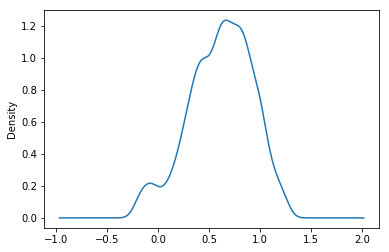

time: 243 ms


In [28]:
mcmc['posterior'][par].plot.density()

## Marginal distribution for $\sigma^2_\epsilon$

True value is $0.3$

In [161]:
par = 1

time: 1 ms


In [162]:
mcmc['posterior'][par].describe()

count    4.500000e+03
mean     6.679998e-06
std      1.834340e-05
min      3.081329e-15
25%      8.169011e-12
50%      3.266635e-08
75%      3.062304e-06
max      1.702004e-04
Name: 1, dtype: float64

time: 5.01 ms


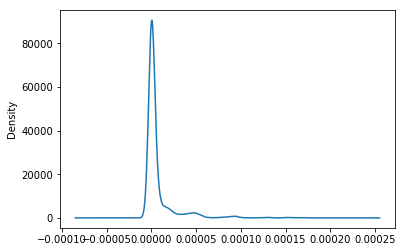

time: 327 ms


In [163]:
mcmc['posterior'][par].plot.density()

## Marginal distribution for $\sigma^2_\xi$

True value is $0.1$

In [ ]:
par = 2

In [ ]:
mcmc['posterior'][par].describe()

In [ ]:
mcmc['posterior'][par].plot.density()

## Marginal distribution for $\sigma^2_\omega$

True value is $0.2$

In [ ]:
par = 3

In [ ]:
mcmc['posterior'][par].describe()

In [ ]:
mcmc['posterior'][par].plot.density()

# Performance Optimization

## Profiling the Kalman Filter

Profiling should always be the first step on every optimization

We'll profile the KF with the true values

In [ ]:
def KF_func(theta):
    T = pd.DataFrame([
        [1,0,0,0],
        [0,-1,-1,-0.7],
        [0,1,0,0],
        [0,0,1,0],
    ])

    H = pd.DataFrame([0.3])

    Q = pd.DataFrame([
        [0.1,0],
        [0,0.2],
    ])

    kf = KF(y=np.array(y), 
                      Z=np.array(Z.astype(float)), 
                      H=np.array(H.astype(float)), 
                      T=np.array(T.astype(float)), 
                      Q=np.array(Q.astype(float)), 
                      a1=np.zeros((4)), 
                      P1=np.identity(4), 
                      R=np.array(R.astype(float)), 
                      nStates=4,)    

    return kf['ll']


In [ ]:
%%snakeviz

KF_func(0)

The problem is that dot products and matrix inversions are already optimized in fortran and C

## Univariate Approach

Makes best use of cython

In [ ]:
def KF_funcUni(theta):
    T = pd.DataFrame([
        [1,0,0,0],
        [0,-1,-1,-0.7],
        [0,1,0,0],
        [0,0,1,0],
    ])

    H = pd.DataFrame([0.3])

    Q = pd.DataFrame([
        [0.1,0],
        [0,0.2],
    ])

    kf = KFU(y=np.array(y), 
                      Z=np.array(Z.astype(float)), 
                      H=np.array(H.astype(float)), 
                      T=np.array(T.astype(float)), 
                      Q=np.array(Q.astype(float)), 
                      a1=np.zeros((4)), 
                      P1=np.identity(4), 
                      R=np.array(R.astype(float)), 
                      nStates=4,)    

    return kf



In [ ]:
%%timeit
KF_func(0)

In [ ]:
%%timeit
KF_funcUni(0)

In [ ]:
%%snakeviz

KF_funcUni(0)

Since dot is already optimized we will move on to cython

In [ ]:
def KF_funcUniC(theta):
    T = pd.DataFrame([
        [1,0,0,0],
        [0,-1,-1,-0.7],
        [0,1,0,0],
        [0,0,1,0],
    ])

    H = pd.DataFrame([0.3])

    Q = pd.DataFrame([
        [0.1,0],
        [0,0.2],
    ])

    kf = KFUC(y=np.array(y), 
                      Z=np.array(Z.astype(float)), 
                      H=np.array(H.astype(float)), 
                      T=np.array(T.astype(float)), 
                      Q=np.array(Q.astype(float)), 
                      a1=np.zeros((4)), 
                      P1=np.identity(4), 
                      R=np.array(R.astype(float)), 
                      nStates=4,)    

    return kf




In [ ]:
%%timeit
KF_funcUniC(0)

Further ideas:

* Eliminate whole line assignments using loops (First check whether that's actually faster)